<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02  Part 2 - TSNE
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [4]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [5]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [6]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [7]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## Preprocess Data For Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [11]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [12]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [13]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [14]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Model and Performance Functions

In [21]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, epochs=200):
  timestamp=int(time.time())
  
  # Compile
  model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[    
        EarlyStopping(monitor='val_accuracy', patience=3),
        ModelCheckpoint('results/model_{val_accuracy:.4f}.h5',
                               save_best_only=True,
                               save_weights_only=False,
                               monitor='val_accuracy')]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x_train, y_train)

  print('Evaluating model performance with validation set')
  model.evaluate(x_valid, y_valid)

  return history, model

In [16]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [17]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [18]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [64]:
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 256)        

In [22]:
# Compile and train
history, model = compile_train_model(model,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-04-19 16:22:23.141925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.0439 - accuracy: 0.2463

2022-04-19 16:22:44.891048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 25s 251ms/step - loss: 2.0439 - accuracy: 0.2463 - val_loss: 2.2489 - val_accuracy: 0.1506
Epoch 2/200
88/88 [==============================] - 18s 200ms/step - loss: 1.6429 - accuracy: 0.4141 - val_loss: 2.1498 - val_accuracy: 0.2126
Epoch 3/200
88/88 [==============================] - 18s 202ms/step - loss: 1.4565 - accuracy: 0.4885 - val_loss: 2.0345 - val_accuracy: 0.3392
Epoch 4/200
88/88 [==============================] - 15s 170ms/step - loss: 1.3325 - accuracy: 0.5407 - val_loss: 1.8861 - val_accuracy: 0.3986
Epoch 5/200
88/88 [==============================] - 15s 164ms/step - loss: 1.2331 - accuracy: 0.5821 - val_loss: 1.4470 - val_accuracy: 0.5812
Epoch 6/200
88/88 [==============================] - 15s 166ms/step - loss: 1.1518 - accuracy: 0.6157 - val_loss: 1.3798 - val_accuracy: 0.5632
Epoch 7/200
88/88 [==============================] - 14s 161ms/step - loss: 1.0808 - accuracy: 0.6462 - val_loss: 1.2965 - val_accuracy: 0.5520
Epoc

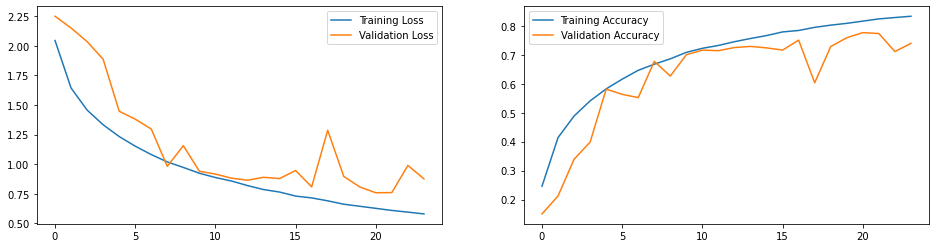

In [23]:
# Plot the training metrics
plot_history(history)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [24]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

2022-04-19 16:29:11.236117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [25]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1000
           1       0.84      0.89      0.86      1000
           2       0.65      0.66      0.65      1000
           3       0.58      0.57      0.57      1000
           4       0.78      0.64      0.70      1000
           5       0.73      0.57      0.64      1000
           6       0.90      0.73      0.80      1000
           7       0.86      0.73      0.79      1000
           8       0.64      0.94      0.76      1000
           9       0.85      0.79      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Accuracy Score: 0.733
Root Mean Square Error: 2.2032702966272657


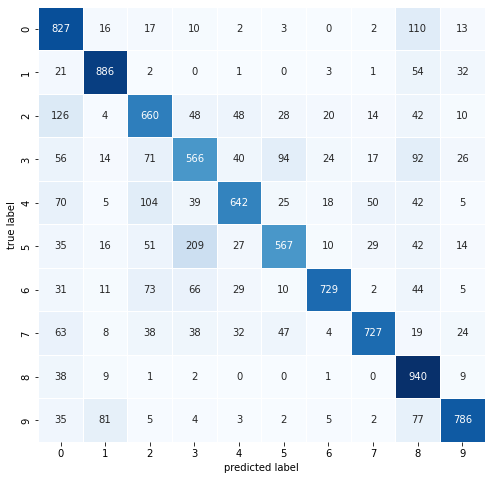

In [26]:
plot_confusion_matrix(y_test,pred1)

In [27]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:5000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

2022-04-19 16:29:13.139828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [28]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/Users/ramundson/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ramundson/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.644s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.972820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.587959
[t-SNE] KL divergence after 300 iterations: 2.152651


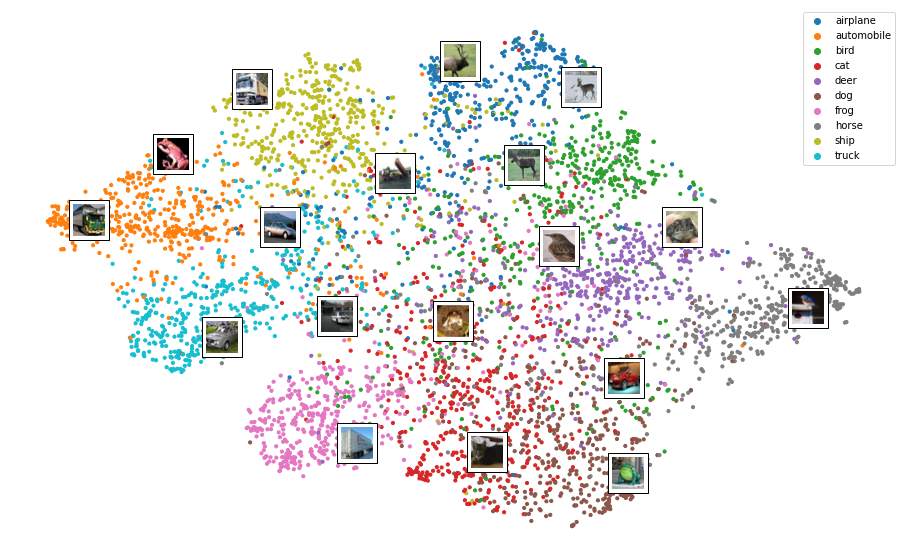

In [29]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [30]:
# Let just try reordering the filter numbers

model_inv = Sequential([
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_inv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 512)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 512)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 6, 6, 256)        

In [31]:
# Compile and train
history, model_inv = compile_train_model(model_inv,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-04-20 21:18:09.345915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.1525 - accuracy: 0.2544

2022-04-20 21:23:53.033602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 348s 4s/step - loss: 2.1525 - accuracy: 0.2544 - val_loss: 2.3055 - val_accuracy: 0.1060
Epoch 2/200
88/88 [==============================] - 164s 2s/step - loss: 1.6723 - accuracy: 0.4116 - val_loss: 2.2173 - val_accuracy: 0.1622
Epoch 3/200
88/88 [==============================] - 154s 2s/step - loss: 1.4795 - accuracy: 0.4818 - val_loss: 2.1339 - val_accuracy: 0.2698
Epoch 4/200
88/88 [==============================] - 147s 2s/step - loss: 1.3492 - accuracy: 0.5332 - val_loss: 1.9263 - val_accuracy: 0.4364
Epoch 5/200
88/88 [==============================] - 149s 2s/step - loss: 1.2517 - accuracy: 0.5733 - val_loss: 1.7222 - val_accuracy: 0.5348
Epoch 6/200
88/88 [==============================] - 140s 2s/step - loss: 1.1764 - accuracy: 0.6027 - val_loss: 1.4370 - val_accuracy: 0.5898
Epoch 7/200
88/88 [==============================] - 132s 1s/step - loss: 1.1138 - accuracy: 0.6284 - val_loss: 1.2799 - val_accuracy: 0.5880
Epoch 8/200
88/88 

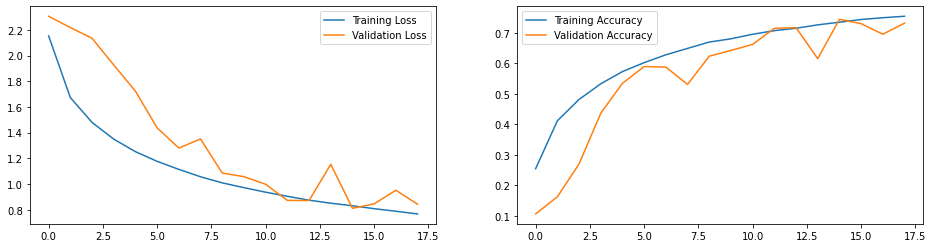

In [32]:
# Plot the training metrics
plot_history(history)

In [33]:
pred1= model_inv.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

2022-04-20 22:03:01.826418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [34]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1000
           1       0.93      0.79      0.85      1000
           2       0.80      0.49      0.61      1000
           3       0.57      0.51      0.54      1000
           4       0.59      0.81      0.68      1000
           5       0.60      0.70      0.65      1000
           6       0.91      0.63      0.75      1000
           7       0.72      0.82      0.77      1000
           8       0.74      0.91      0.82      1000
           9       0.70      0.91      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000

Accuracy Score: 0.7226
Root Mean Square Error: 2.2239604313026793


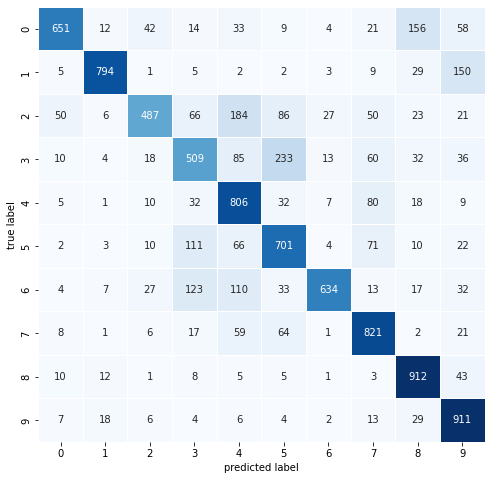

In [35]:
plot_confusion_matrix(y_test,pred1)

In [69]:
from model_profiler import model_profiler

Batch_size = 100
profile = model_profiler(model, Batch_size)

print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0015  | BFLOPs  |
| GPU Memory Requirement           | 0.0952  | GB      |
| Model Parameters                 | 2.2711  | Million |
| Memory Required by Model Weights | 8.6636  | MB      |


2022-04-24 16:09:55.980154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 16:09:55.980222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [67]:
from model_profiler import model_profiler

Batch_size = 100
profile = model_profiler(model_inv, Batch_size)

print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0043  | BFLOPs  |
| GPU Memory Requirement           | 0.2838  | GB      |
| Model Parameters                 | 1.6917  | Million |
| Memory Required by Model Weights | 6.4532  | MB      |


2022-04-24 16:05:24.878506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 16:05:24.878537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
model_lght = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_lght.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 6, 6, 128)        

In [37]:
# Compile and train
history, model_lght = compile_train_model(model_lght,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-04-21 16:09:35.444645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.0966 - accuracy: 0.2781

2022-04-21 16:09:47.026398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 13s 100ms/step - loss: 2.0966 - accuracy: 0.2781 - val_loss: 2.3067 - val_accuracy: 0.1128
Epoch 2/200
88/88 [==============================] - 6s 69ms/step - loss: 1.6607 - accuracy: 0.4104 - val_loss: 2.2216 - val_accuracy: 0.1236
Epoch 3/200
88/88 [==============================] - 6s 74ms/step - loss: 1.4928 - accuracy: 0.4777 - val_loss: 2.1259 - val_accuracy: 0.3378
Epoch 4/200
88/88 [==============================] - 7s 74ms/step - loss: 1.3846 - accuracy: 0.5177 - val_loss: 1.9477 - val_accuracy: 0.4172
Epoch 5/200
88/88 [==============================] - 6s 65ms/step - loss: 1.2965 - accuracy: 0.5591 - val_loss: 1.7086 - val_accuracy: 0.5386
Epoch 6/200
88/88 [==============================] - 6s 67ms/step - loss: 1.2341 - accuracy: 0.5822 - val_loss: 1.5111 - val_accuracy: 0.5538
Epoch 7/200
88/88 [==============================] - 6s 69ms/step - loss: 1.1787 - accuracy: 0.6057 - val_loss: 1.2477 - val_accuracy: 0.6088
Epoch 8/200
88/8

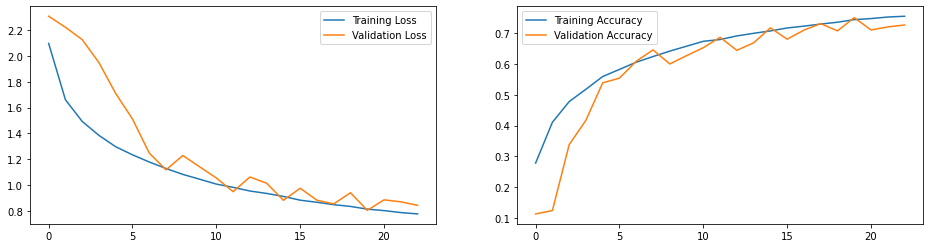

In [38]:
# Plot the training metrics
plot_history(history)

In [45]:
pred1= model_lght.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

2022-04-21 20:32:46.980134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1000
           1       0.92      0.82      0.86      1000
           2       0.55      0.69      0.61      1000
           3       0.70      0.44      0.54      1000
           4       0.56      0.81      0.66      1000
           5       0.83      0.46      0.59      1000
           6       0.70      0.88      0.78      1000
           7       0.83      0.74      0.78      1000
           8       0.76      0.91      0.83      1000
           9       0.83      0.84      0.84      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Accuracy Score: 0.7295
Root Mean Square Error: 2.075355391252303


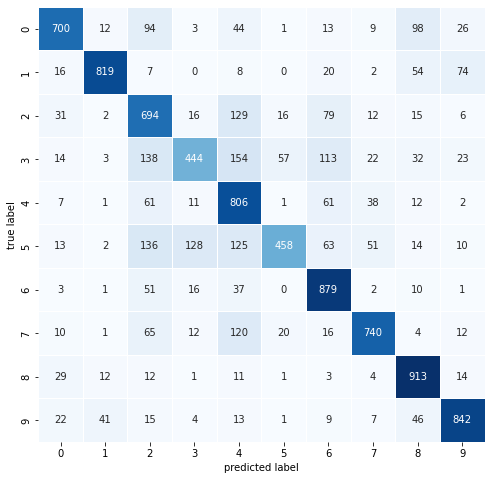

In [46]:
plot_confusion_matrix(y_test,pred1)

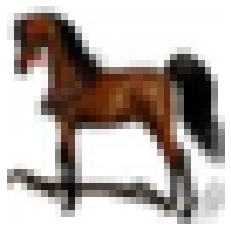

In [47]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

2022-04-21 20:32:03.150354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_23459/1969454917.py:38: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


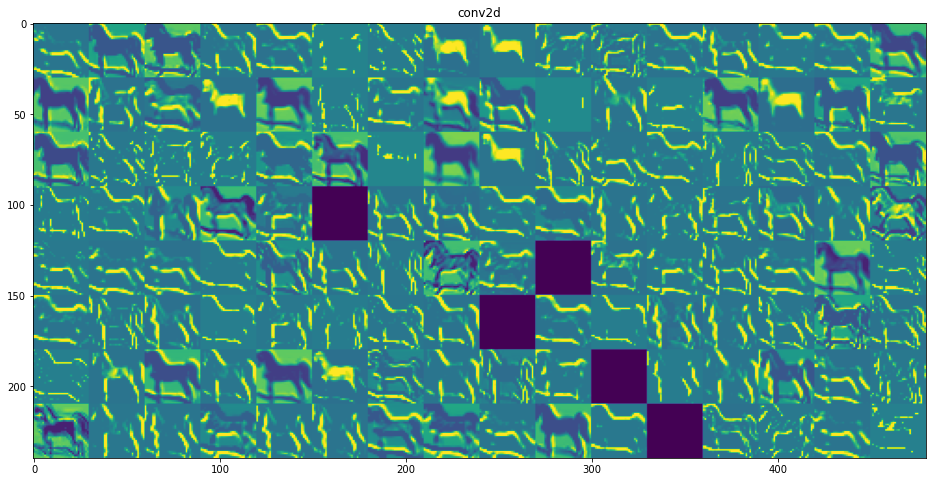

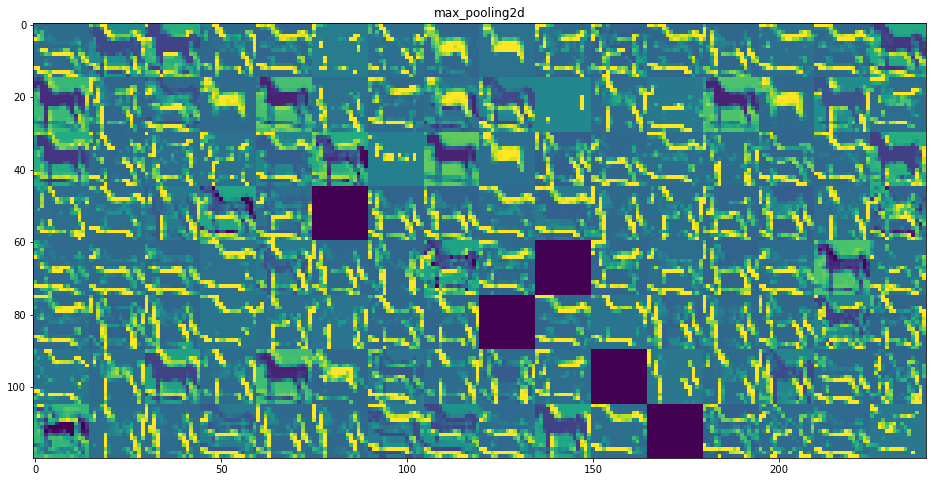

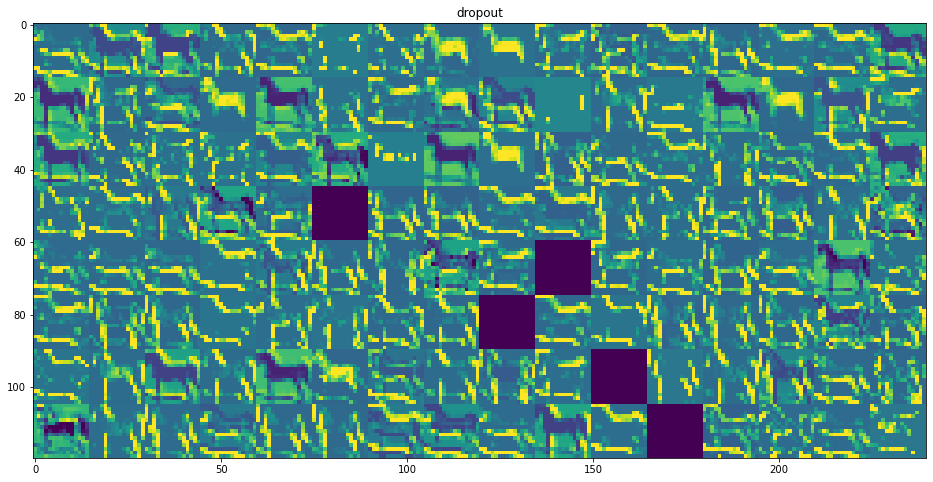

In [44]:
# Now lets look at the activation layers

def draw_tiles(model):
    # Extracts the outputs of the top 8 layers:
    layer_outputs = [layer.output for layer in model.layers[:8]]
    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(img_tensor)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[:3]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show();
    
draw_tiles(model)

2022-04-21 20:33:18.245130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_23459/1969454917.py:38: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


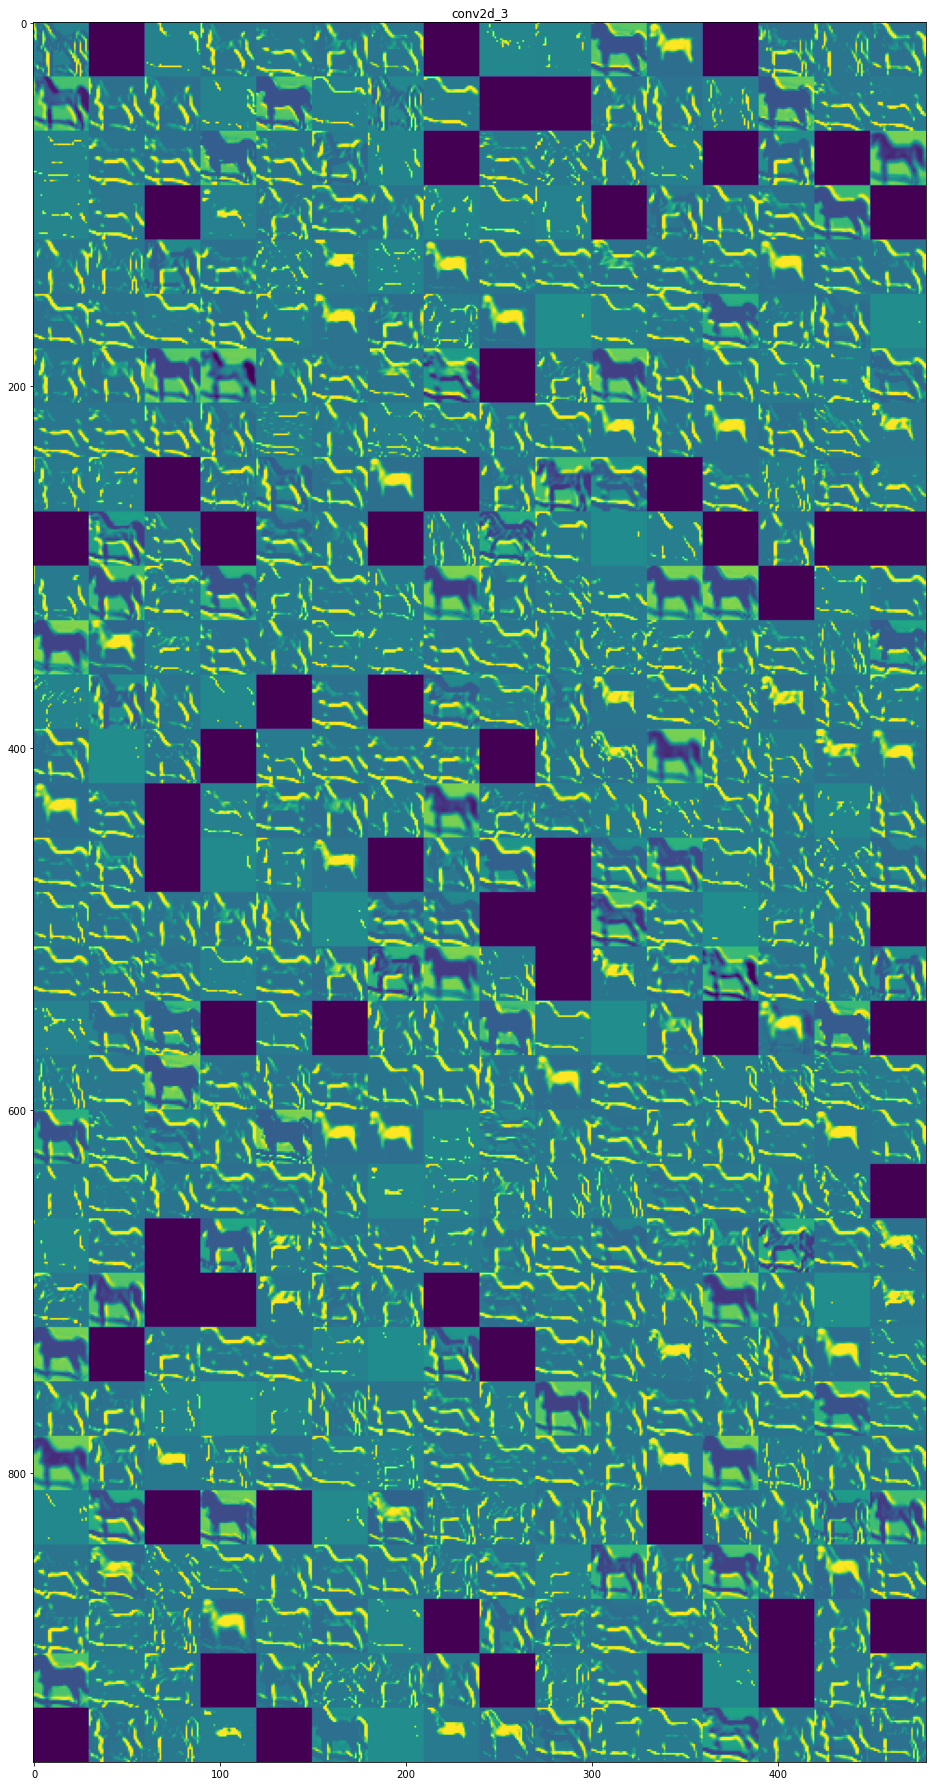

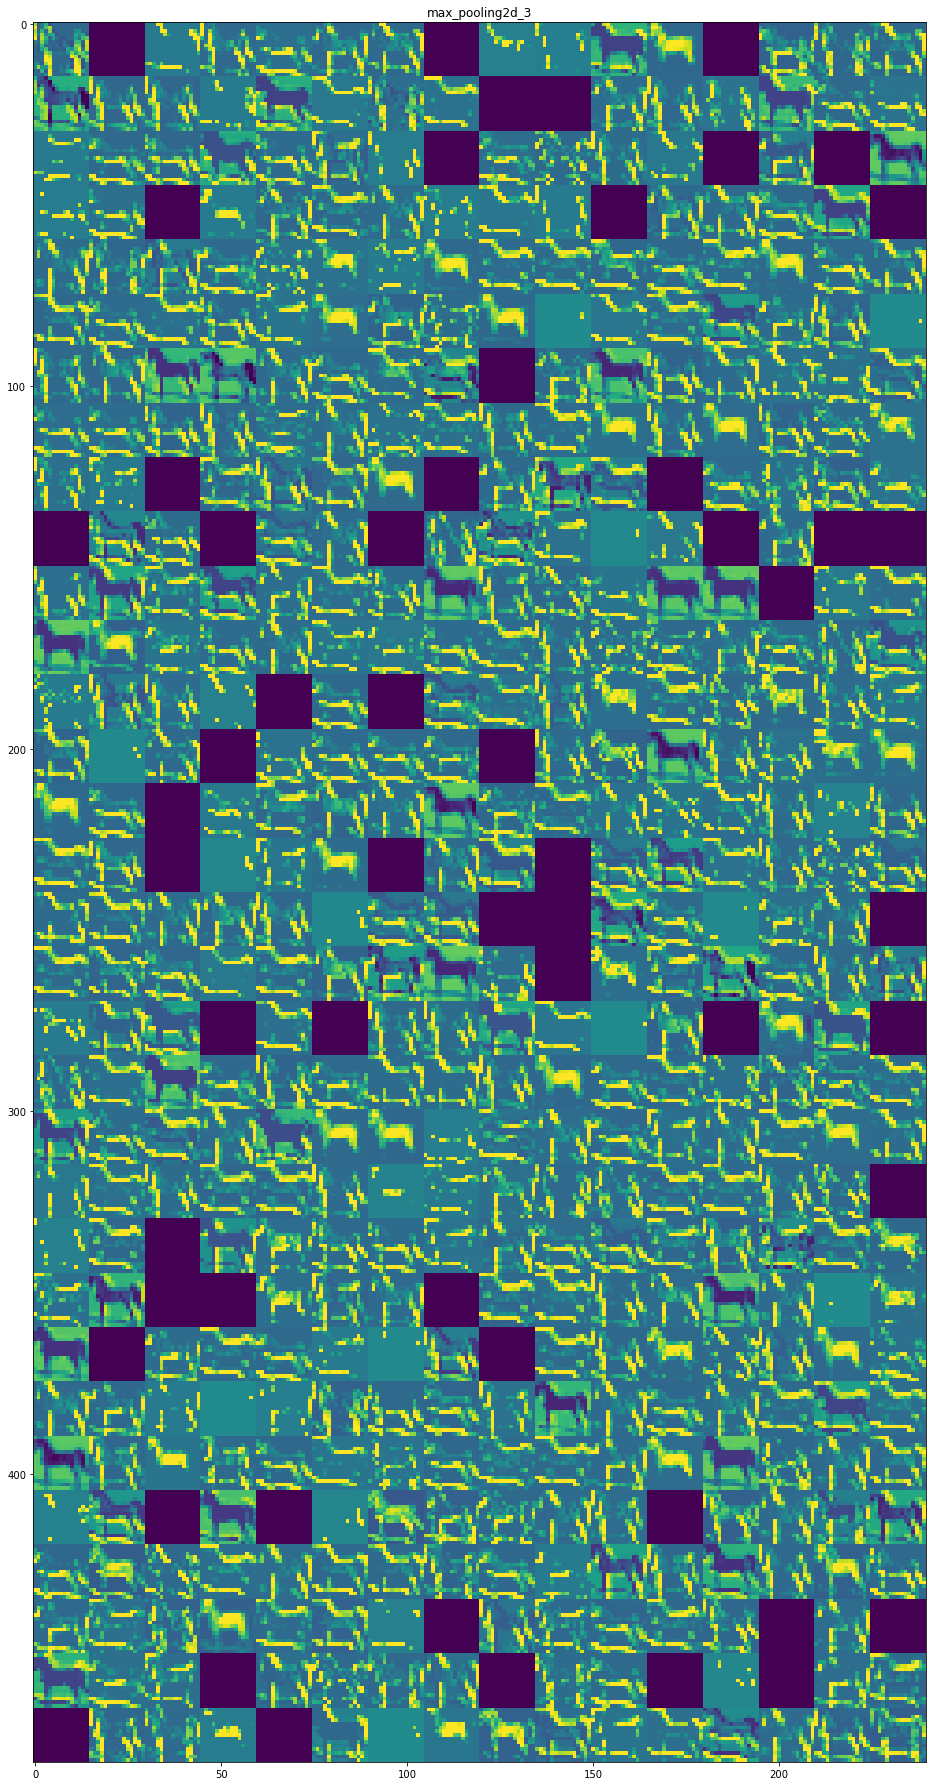

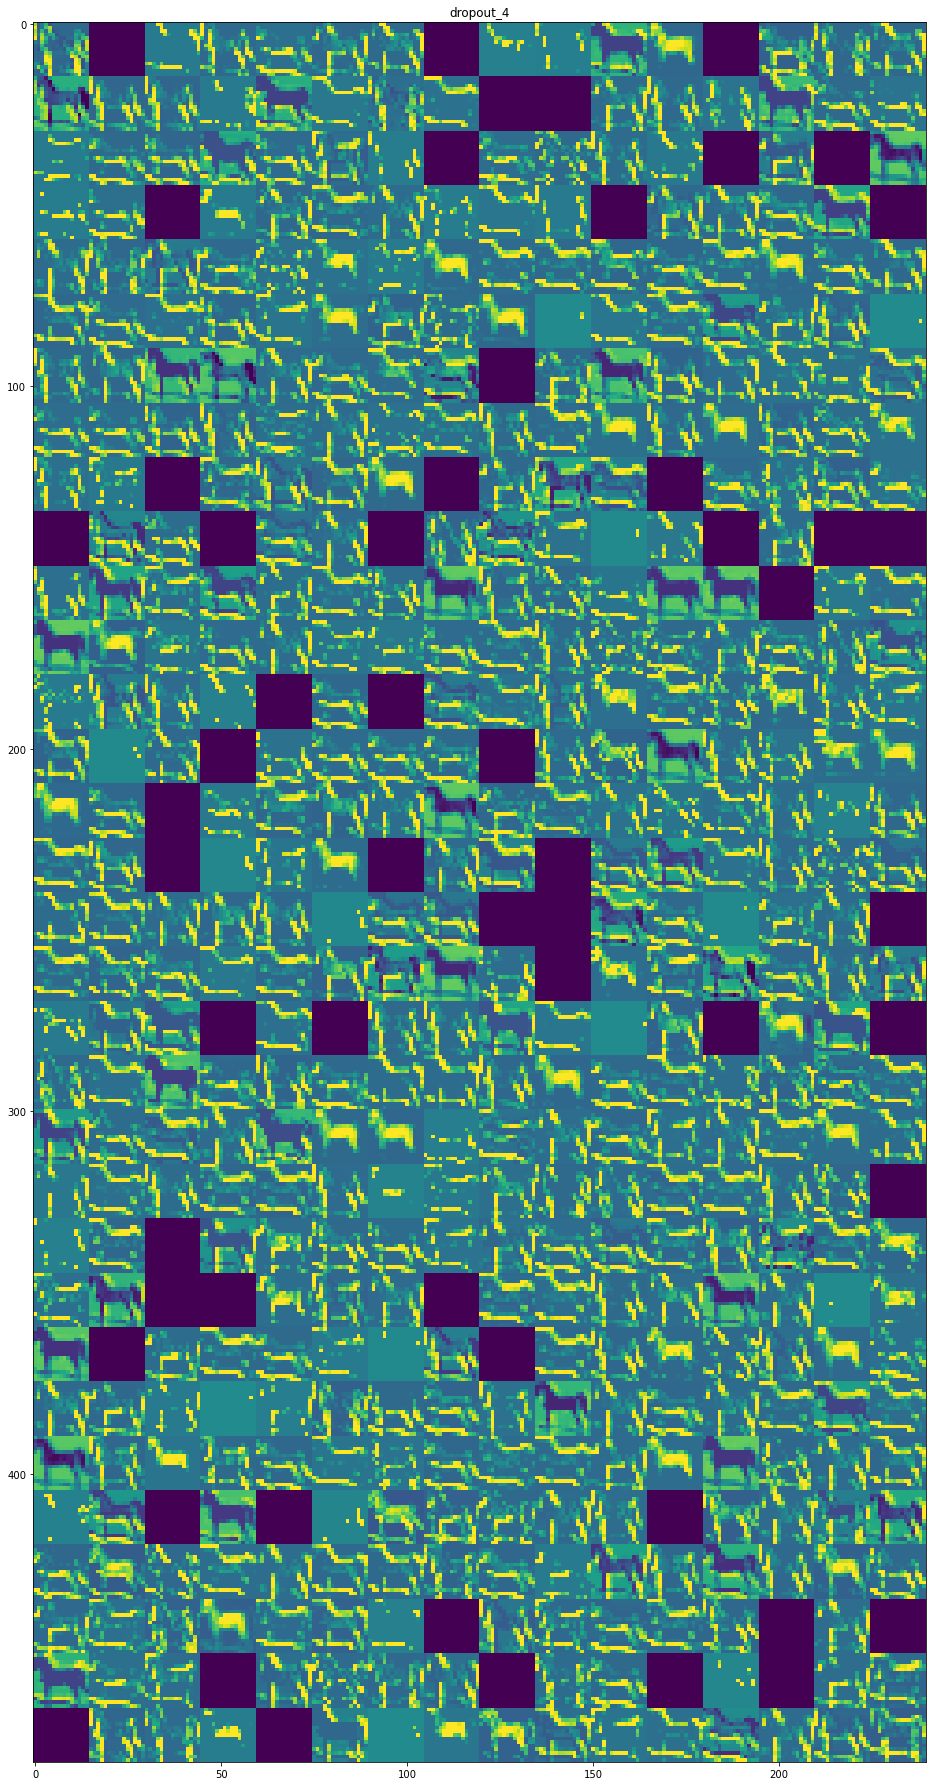

In [48]:
draw_tiles(model_inv)

2022-04-21 20:34:26.255266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_23459/1969454917.py:38: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


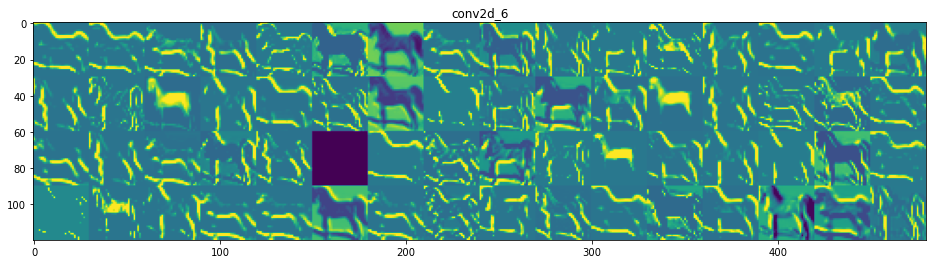

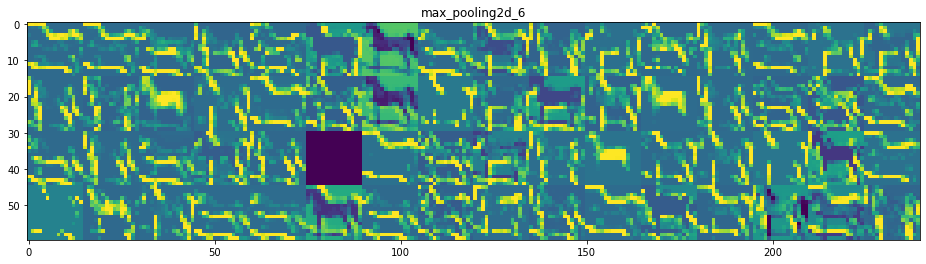

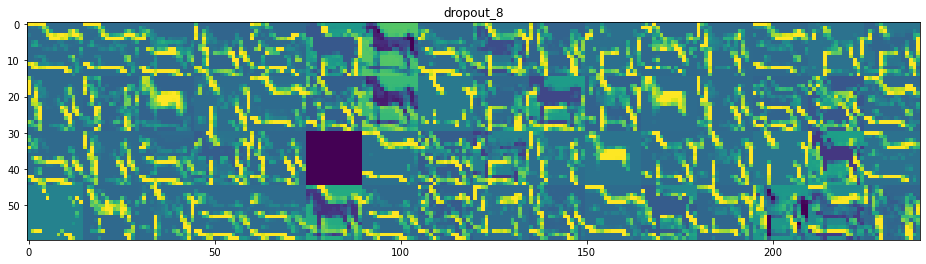

In [49]:
draw_tiles(model_lght)

In [78]:
# Use batch normalization

model_bn = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  BatchNormalization(),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_bn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 15, 15, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                      

In [79]:
# Compile and train
history, model_bn = compile_train_model(model_bn,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-04-24 19:27:01.351258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.2898 - accuracy: 0.2473

2022-04-24 19:27:17.745617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 17s 175ms/step - loss: 2.2898 - accuracy: 0.2473 - val_loss: 2.3072 - val_accuracy: 0.0986
Epoch 2/200
88/88 [==============================] - 14s 162ms/step - loss: 2.1345 - accuracy: 0.3362 - val_loss: 2.3190 - val_accuracy: 0.0970
Epoch 3/200
88/88 [==============================] - 15s 162ms/step - loss: 2.0531 - accuracy: 0.3663 - val_loss: 2.3317 - val_accuracy: 0.0970
Epoch 4/200
88/88 [==============================] - 14s 159ms/step - loss: 1.9666 - accuracy: 0.3855 - val_loss: 2.3463 - val_accuracy: 0.0970
Finished model training in 63s
Model performance with training set
1407/1407 [==============================] - 15s 10ms/step - loss: 2.3439 - accuracy: 0.1003
Evaluating model performance with validation set
157/157 [==============================] - 2s 10ms/step - loss: 2.3463 - accuracy: 0.0970


In [82]:
pred1= model_lght.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1000
           1       0.92      0.82      0.86      1000
           2       0.55      0.69      0.61      1000
           3       0.70      0.44      0.54      1000
           4       0.56      0.81      0.66      1000
           5       0.83      0.46      0.59      1000
           6       0.70      0.88      0.78      1000
           7       0.83      0.74      0.78      1000
           8       0.76      0.91      0.83      1000
           9       0.83      0.84      0.84      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Accuracy Score: 0.7295
Root Mean Square Error: 2.075355391252303


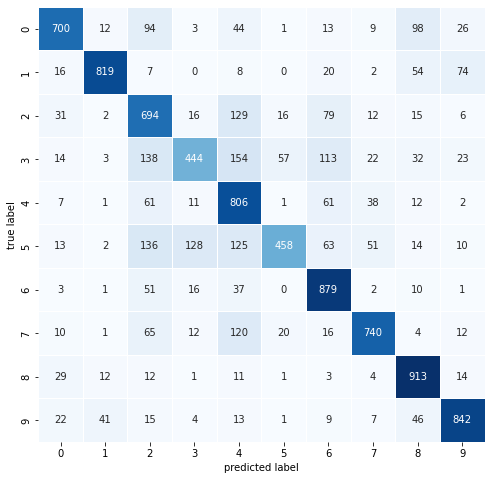

In [83]:
plot_confusion_matrix(y_test,pred1)